In [1]:
import random
import torch
import numpy as np

In [2]:
def set_seed(seed = 42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.use_deterministic_algorithms(True)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False



In [3]:
import os
import torch
import torch.nn as nn
import snntorch as snn
import numpy as np

class SpikingReservoirLoaded(nn.Module):
    def __init__(self, threshold, beta_reservoir, reservoir_size, device,
                 reset_delay, input_lif_beta, reset_mechanism,
                 connectivity_matrix_path):
        """
        A reservoir of spiking LIF neurons that loads its recurrent connectivity
        matrix from a file and directly injects the input signal into the reservoir neurons.
        
        Args:
            threshold (float): The spiking threshold (V_threshold). This value is directly injected at time step 0.
            beta_reservoir (float): The decay factor for reservoir neurons.
            reservoir_size (int): Number of reservoir neurons.
            device (str): 'cpu' or 'cuda'.
            reset_delay (int): Reset delay for neurons.
            input_lif_beta (float): (Not used now; provided for compatibility.)
            reset_mechanism (str): e.g. "zero".
            connectivity_matrix_path (str): Path to the .npy file for the recurrent connectivity matrix.
        """
        super(SpikingReservoirLoaded, self).__init__()
        self.device = device
        self.reservoir_size = reservoir_size

        # We remove the input linear layer and input LIF.
        # Instead, the input signal (a scalar per time step) will be directly replicated to all reservoir neurons.
        
        self.reservoir_lif = snn.RLeaky(beta=beta_reservoir,
                                        linear_features=reservoir_size,
                                        threshold=threshold,
                                        spike_grad=None,
                                        reset_mechanism=reset_mechanism,
                                        reset_delay=reset_delay,
                                        learn_recurrent=False,
                                        all_to_all=True)
        
        # Load the connectivity matrix from the path file and assign it to the recurrent weights.
        # W = torch.tensor(np.load(connectivity_matrix_path), dtype=torch.float32)
        # if W.shape != (reservoir_size, reservoir_size):
        #     raise ValueError("Loaded connectivity matrix shape does not match reservoir_size.")
        # with torch.no_grad():
        #     self.reservoir_lif.recurrent.weight.copy_(W)

        W = torch.full((reservoir_size, reservoir_size), threshold/10, dtype=torch.float32)
        with torch.no_grad():
            self.reservoir_lif.recurrent.weight.copy_(W)

        self.to(self.device)

    def forward(self, x):
        """
        Simulate reservoir dynamics.
        x: Input tensor of shape (batch_size, time_steps, 1)
        Returns:
            avg_firing_rate, spike_record, mem_record.
        """
        # Direct injection mode (no input LIF all'inizio, no nn.Linear scaling).
        batch_size, time_steps, _ = x.shape # shape: (batch_size, time_steps, 1)
        x = x.to(self.device)
        # Initialize the reservoir membrane potential and spike state.
        reservoir_mem = torch.zeros(batch_size, self.reservoir_size, device=self.device)
        reservoir_spk = torch.zeros(batch_size, self.reservoir_size, device=self.device)
        spike_record = []
        mem_record = []

        for t in range(time_steps):
            x_t = x[:, t, :]  # shape: (batch_size, 1)
            input_current = x_t.repeat(1, self.reservoir_size) # this means: repeat x_t NOT along the batch dimension (0), but along the 1st dimension, which is reservoir_size. so now input_current has shape (batch_size, reservoir_size) with x_t equal for each reservoir neuron.
            reservoir_spk, reservoir_mem = self.reservoir_lif(input_current, reservoir_spk, reservoir_mem)
            spike_record.append(reservoir_spk.detach().cpu().numpy())
            mem_record.append(reservoir_mem.detach().cpu().numpy())

        spike_record = np.array(spike_record)  # shape: (time_steps, batch_size, reservoir_size)
        mem_record = np.array(mem_record)
        avg_firing_rate = spike_record.mean()
        return avg_firing_rate, spike_record, mem_record

def generate_input_signal(V_threshold, time_steps=50):
    """
    Create an input signal:
      - First time step = V_threshold (forcing a spike)
      - Remaining time steps = 0.
    Returns a tensor of shape (1, time_steps, 1).
    """
    signal = np.zeros(time_steps, dtype=np.float32)
    signal[0] = V_threshold*2
    input_tensor = torch.tensor(signal, dtype=torch.float32).unsqueeze(0).unsqueeze(-1) # shape: (batch_size, time_steps, reservoir_size)
    return input_tensor

### Visualizing

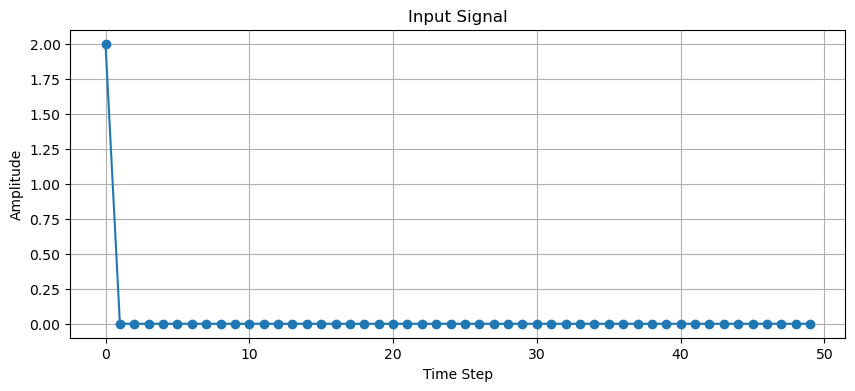

At time step 0, neurons [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] spiked.
At time step 1, neurons [1, 4] spiked.
At time step 2, no neurons spiked.
At time step 3, no neurons spiked.
At time step 4, no neurons spiked.
At time step 5, no neurons spiked.
At time step 6, no neurons spiked.
At time step 7, no neurons spiked.
At time step 8, no neurons spiked.
At time step 9, no neurons spiked.
At time step 10, no neurons spiked.
At time step 11, no neurons spiked.
At time step 12, no neurons spiked.
At time step 13, no neurons spiked.
At time step 14, no neurons spiked.
At time step 15, no neurons spiked.
At time step 16, no neurons spiked.
At time step 17, no neurons spiked.
At time step 18, no neurons spiked.
At time step 19, no neurons spiked.
At time step 20, no neurons spiked.
At time step 21, no neurons spiked.
At time step 22, no neurons spiked.
At time step 23, no neurons spiked.
At time step 24, no neurons spiked.
At time step 25, no neurons spiked.
At time step 26, no neurons spiked.
At tim

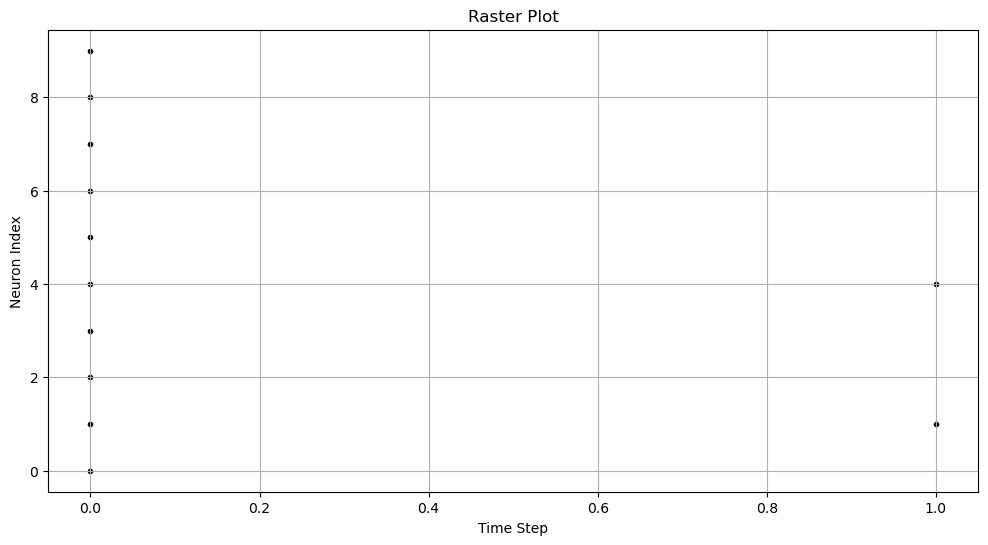

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_raster(spike_record, title="Raster Plot"):
    """
    Plot a raster plot of the spike_record.
    
    Args:
        spike_record (numpy.ndarray): Array of shape (time_steps, batch_size, reservoir_size)
                                      representing the spike events.
                                      For plotting, we assume batch_size = 1.
        title (str): Title of the plot.
    """
    # remove batch size dimension since I have only one batch rn
    spike_record = np.squeeze(spike_record, axis=1)  # Now shape is (time_steps, reservoir_size)
    time_steps, reservoir_size = spike_record.shape

    plt.figure(figsize=(12, 6))
    
    for neuron in range(reservoir_size):
        # Find the time steps where this neuron fired (assuming spike > 0 means a spike occurred)
        spike_times = np.where(spike_record[:, neuron] > 0)[0]
        plt.scatter(spike_times, np.full_like(spike_times, neuron), marker='.', color='black')
    
    plt.xlabel("Time Step")
    plt.ylabel("Neuron Index")
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_input_signal(signal, title="Input Signal"):
    """
    Plot the input signal over time.
    
    Args:
        signal (torch.Tensor): Tensor of shape (1, time_steps, 1) representing the input signal.
        title (str): Title of the plot.
    """
    # Remove useless dimensions to get a 1D array of signal values.
    signal_values = signal.squeeze().numpy()
    time_steps = range(len(signal_values))
    
    plt.figure(figsize=(10, 4))
    plt.plot(time_steps, signal_values, marker='o', linestyle='-')
    plt.xlabel("Time Step")
    plt.ylabel("Amplitude")
    plt.title(title)
    plt.grid(True)
    plt.show()

def print_spike_info(spike_record):
    """
    Print which neurons spiked at each time step.
    
    Args:
        spike_record (numpy.ndarray): Array of shape (time_steps, batch_size, reservoir_size)
                                      representing the spike events.
                                      Assumes batch_size = 1.
    """
    # Remove the batch dimension (assumes batch_size=1)
    spike_record = np.squeeze(spike_record, axis=1)  # Now shape is (time_steps, reservoir_size)
    time_steps, reservoir_size = spike_record.shape
    
    for t in range(time_steps):
        # Find indices of neurons that spiked at time step t.
        spiking_neurons = np.where(spike_record[t] > 0)[0]
        if spiking_neurons.size > 0:
            print(f"At time step {t}, neurons {spiking_neurons.tolist()} spiked.")
        else:
            print(f"At time step {t}, no neurons spiked.")

if __name__ == '__main__':
    # Assume V_threshold is defined and we have our reservoir model set up.
    V_threshold = 1.0 

    set_seed(42)
    input_signal = generate_input_signal(V_threshold)
    plot_input_signal(input_signal)


    reservoir = SpikingReservoirLoaded(
        threshold=V_threshold,
        beta_reservoir=0.8,
        reservoir_size=10,       
        device='cpu',
        reset_delay=0,
        input_lif_beta=0.01,  # ignora, solo per compatibilità con altre funzioni     
        reset_mechanism="zero",
        connectivity_matrix_path="dummy_path.npy"  # ignora pure questo
    )


    # forward pass to get spike records
    avg_firing_rate, spike_record, mem_record = reservoir(input_signal)

   
    print_spike_info(spike_record)
    plot_raster(spike_record)